QA 전체 다시 돌린 걸로 mecab 사용해서 형태소 분석하고 불용어 제거 / 조사 제거  
조사 제거한 걸로 저장해서 버트 돌리기

## 라이브러리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Todays_Chatbot/Preprocessing/data

/content/drive/.shortcut-targets-by-id/1yQ-EFTAnZETmcDATUTjJGzUXrx_KmHG_/Todays_Chatbot/Preprocessing/data


In [3]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re
import os
import pickle

## 데이터 로드

In [4]:
qa_data = pd.read_csv('/content/drive/MyDrive/Todays_Chatbot/Preprocessing/data/question_table_drop_clean_spellcheck.csv')

In [5]:
qa_data.head()

,product_id,product_name,product_option,user_id,user_buyer,is_secret,label,question,question_time,answer,answer_time,question_clean,answer_clean,question_spellcheck,answer_spellcheck
0,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3077236,True,False,환불,상부 연결 목재 중 하나가 나사산이 덜 파져 있네요;; 조립하다 목재가 갈라져버립니...,2021-03-18T16:52:34.000+09:00,안녕하세요 고객님 먼데이하우스입니다.\r\n불편을 드려 죄송합니다.\r\n유선상 연...,2021-03-18T18:19:46.000+09:00,상부 연결 목재 중 하나가 나사산이 덜 파져 있네요 조립하다 목재가 갈라져버립니다 ...,안녕하세요 고객님 먼데이하우스입니다 불편을 드려 죄송합니다 유선상 연락을 드렸으나 ...,상부 연결 목재 중 하나가 나사산이 덜 파죠 있네요 조립하다 목재가 갈라져버립니다 ...,안녕하세요 고객님 먼데이 하우스입니다 불편을 드려 죄송합니다 유선상 연락을 드렸으나...
1,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3076525,True,False,상품,배송 언제 되는걸까요...?,2021-03-18T15:31:16.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n유선상 연락 및 안내드렸습니다.\r\n...,2021-03-18T15:52:19.000+09:00,배송 언제 되는걸까요,안녕하세요 고객님 먼데이하우스입니다 유선상 연락 및 안내드렸습니다 감사합니다 1,배송 언제 되는 걸까요,안녕하세요 고객님 먼데이 하우스입니다 유선상 연락 및 안내드렸습니다 감사합니다 1
2,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 화이트,3076317,True,False,배송,구매 하였는데 배송 메모는 무시해주세요ㅠ 다른곳에서 산거 수정을 못했어요ㅠㅠ 빠른배...,2021-03-18T15:05:32.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n네 ~~주문확인되는데로 최대한 빠른 배...,2021-03-18T16:08:01.000+09:00,구매 하였는데 배송 메모는 무시해주세요 다른곳에서 산거 수정을 못했어요 빠른배송 부...,안녕하세요 고객님 먼데이하우스입니다 네 주문확인되는데로 최대한 빠른 배송위해 최선을...,구매하였는데 배송 메모는 무시해주세요 다른 곳에서 산거 수정을 못했어요 빠른 배송 ...,안녕하세요 고객님 먼데이 하우스입니다 네 주문 확인되는 데로 최대한 빠른 배송 위해...
3,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 블랙,3073853,True,False,상품,조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요.. 육각 나사 렌...,2021-03-18T10:23:56.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n따로 발송해드리도록 하겠습니다.\r\n...,2021-03-18T15:26:29.000+09:00,조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요 육각 나사 렌치 ...,안녕하세요 고객님 먼데이하우스입니다 따로 발송해드리도록 하겠습니다 감사합니다 1,조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요 육각 나사 렌치 ...,안녕하세요 고객님 먼데이 하우스입니다 따로 발송해드리도록 하겠습니다 감사합니다 1
4,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3070524,False,False,배송,주문해서 다음주 월요일(3/22)에 받고싶은데..언제 주문하면될까요?,2021-03-17T19:50:58.000+09:00,안녕하세요 고객님 먼데이하우스입니다.\r\n월요일 수령은 장담드리기 어렵습니다.주말...,2021-03-18T16:45:11.000+09:00,주문해서 다음주 월요일 3 22 에 받고싶은데 언제 주문하면될까요,안녕하세요 고객님 먼데이하우스입니다 월요일 수령은 장담드리기 어렵습니다 주말 휴무이...,주문해서 다음 주 월요일 3 22에 받고 싶은데 언제 주문하면 될까요,안녕하세요 고객님 먼데이 하우스입니다 월요일 수령은 장담 드리기 어렵습니다 주말 휴...


In [6]:
question = qa_data['question_spellcheck']
question.head()

0    상부 연결 목재 중 하나가 나사산이 덜 파죠 있네요 조립하다 목재가 갈라져버립니다 ...
1                                         배송 언제 되는 걸까요
2    구매하였는데 배송 메모는 무시해주세요 다른 곳에서 산거 수정을 못했어요 빠른 배송 ...
3    조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요 육각 나사 렌치 ...
4               주문해서 다음 주 월요일 3 22에 받고 싶은데 언제 주문하면 될까요
Name: question_spellcheck, dtype: object

In [7]:
answer = qa_data['answer_spellcheck']
answer.head()

0    안녕하세요 고객님 먼데이 하우스입니다 불편을 드려 죄송합니다 유선상 연락을 드렸으나...
1        안녕하세요 고객님 먼데이 하우스입니다 유선상 연락 및 안내드렸습니다 감사합니다 1
2    안녕하세요 고객님 먼데이 하우스입니다 네 주문 확인되는 데로 최대한 빠른 배송 위해...
3        안녕하세요 고객님 먼데이 하우스입니다 따로 발송해드리도록 하겠습니다 감사합니다 1
4    안녕하세요 고객님 먼데이 하우스입니다 월요일 수령은 장담 드리기 어렵습니다 주말 휴...
Name: answer_spellcheck, dtype: object

## Mecab 설치

In [ ]:
# ! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [8]:
cd Mecab-ko-for-Google-Colab/

/content/drive/.shortcut-targets-by-id/1yQ-EFTAnZETmcDATUTjJGzUXrx_KmHG_/Todays_Chatbot/Preprocessing/data/Mecab-ko-for-Google-Colab


In [9]:
ls

answer_mecab_tokens.csv  install_mecab-ko_on_colab190912.sh         LICENSE
images/                  install_mecab-ko_on_colab_light_210108.sh  README.md


In [10]:
! bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 57.6MB/s 
     |████████████████████████████████| 460kB 36.6MB/s 
     |████████████████████████████████| 92kB 7.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-03-28 13:41:37--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::22c2:513, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=oElzMhpkCz4cZaprucZ2Jz%2BlNV4%3D&Expires=1616940698&AWSAccessKeyId=AKIA6KOSE3B

## Mecab

In [11]:
from konlpy.tag import Mecab

In [12]:
mecab = Mecab()

In [13]:
for i in range(5):
    print(mecab.pos(question[i]))

[('상부', 'NNG'), ('연결', 'NNG'), ('목재', 'NNG'), ('중', 'NNB'), ('하나', 'NR'), ('가', 'JKS'), ('나사산', 'NNG'), ('이', 'JKS'), ('덜', 'MAG'), ('파', 'VV'), ('죠', 'EC'), ('있', 'VX'), ('네요', 'EC'), ('조립', 'NNG'), ('하', 'XSV'), ('다', 'EC'), ('목재', 'NNG'), ('가', 'JKS'), ('갈라져', 'VV+EC'), ('버립니다', 'VX+EC'), ('나사', 'NNG'), ('가', 'JKS'), ('잘못', 'MAG'), ('된', 'VV+ETM'), ('각도', 'NNG'), ('로', 'JKB'), ('들어간', 'VV+ETM'), ('것', 'NNB'), ('도', 'JX'), ('아니', 'VCN'), ('고', 'EC'), ('나사산', 'NNG'), ('이', 'JKS'), ('덜', 'MAG'), ('파', 'VV'), ('져서', 'EC+VX+EC'), ('나사', 'NNG'), ('가', 'JKS'), ('2', 'SN'), ('3', 'SN'), ('정도', 'NNG'), ('밖에', 'JX'), ('안', 'MAG'), ('들어갔', 'VV+EP'), ('는데', 'EC'), ('더', 'MAG'), ('안', 'MAG'), ('들', 'VV'), ('어', 'EC'), ('가지', 'VX'), ('다가', 'EC'), ('목재', 'NNG'), ('가', 'JKS'), ('갈라져', 'VV+EC'), ('버렸', 'VX+EP'), ('어요', 'EF'), ('환불', 'NNG'), ('요청', 'NNG'), ('드립니다', 'VV+EC')]
[('배송', 'NNG'), ('언제', 'MAG'), ('되', 'VV'), ('는', 'ETM'), ('걸까요', 'NNB+VCP+EC')]
[('구매', 'NNG'), ('하', 'XSV'), ('였', 'EP'), ('는

In [14]:
for i in range(5):
    print(mecab.pos(answer[i]))

[('안녕', 'NNG'), ('하', 'XSV'), ('세요', 'EP+EF'), ('고객', 'NNG'), ('님', 'XSN'), ('먼데이', 'NNP'), ('하우스', 'NNP'), ('입니다', 'VCP+EF'), ('불편', 'NNG'), ('을', 'JKO'), ('드려', 'VV+EC'), ('죄송', 'XR'), ('합니다', 'XSA+EF'), ('유선', 'NNG'), ('상', 'XSN'), ('연락', 'NNG'), ('을', 'JKO'), ('드렸', 'VV+EP'), ('으나', 'EC'), ('부재중', 'NNG'), ('이', 'VCP'), ('시', 'EP'), ('네요', 'EF'), ('안타깝', 'VA'), ('게', 'EC'), ('도', 'JX'), ('조립', 'NNG'), ('을', 'JKO'), ('시작', 'NNG'), ('하', 'XSV'), ('셨', 'EP+EP'), ('으면', 'EC'), ('반품', 'NNG'), ('이', 'JKS'), ('어렵', 'VA'), ('습니다', 'EF'), ('사이트', 'NNG'), ('내', 'NNB'), ('하', 'VV'), ('자', 'EC'), ('사진', 'NNG'), ('과', 'JKB'), ('함께', 'MAG'), ('교환', 'NNG'), ('신청', 'NNG'), ('을', 'JKO'), ('해', 'VV+EC'), ('주', 'VX'), ('시', 'EP'), ('면', 'EC'), ('하자', 'NNG'), ('인', 'VCP+ETM'), ('부분', 'NNG'), ('만', 'JX'), ('재', 'XPN'), ('출고', 'NNG'), ('하', 'XSV'), ('고', 'EC'), ('있', 'VX'), ('습니다', 'EF'), ('감사', 'NNG'), ('합니다', 'XSV+EC'), ('3', 'SN')]
[('안녕', 'NNG'), ('하', 'XSV'), ('세요', 'EP+EF'), ('고객', 'NNG'), ('님', 'X

In [15]:
question = question.astype(str)

question_mecab = []
for i in range(len(question)):
    if question[i] == 'NaN':
        question_mecab.append('nan')
    else:
        question_mecab.append(mecab.pos(question[i]))

In [16]:
answer = answer.astype(str)

answer_mecab = []
for i in range(len(answer)):
    if answer[i] == 'NaN':
        answer_mecab.append('nan')
    else:
        answer_mecab.append(mecab.pos(answer[i]))

#### 줌 미팅용 확인 코드

In [ ]:
len(question_mecab), len(answer_mecab)

(92559, 92559)

In [ ]:
que_mecab = []
for que in question_mecab:
    for q in que:
        que_mecab.append(q)

In [ ]:
ans_mecab = []
for ans in answer_mecab:
    for a in ans:
        ans_mecab.append(a)

In [ ]:
len(que_mecab), len(ans_mecab)

(2324140, 4343543)

In [ ]:
len(set(que_mecab)), len(set(ans_mecab))

(25511, 17987)

## 불용어 제거 (실행x)

In [ ]:
with open('/content/drive/MyDrive/Todays_Chatbot/Preprocessing/data/stopwords-ko.txt', 'r') as file:
    stopwords = file.readlines()

In [ ]:
stopwords

['아\n',
 '휴\n',
 '아이구\n',
 '아이쿠\n',
 '아이고\n',
 '어\n',
 '나\n',
 '우리\n',
 '저희\n',
 '따라\n',
 '의해\n',
 '을\n',
 '를\n',
 '에\n',
 '의\n',
 '가\n',
 '으로\n',
 '로\n',
 '에게\n',
 '뿐이다\n',
 '의거하여\n',
 '근거하여\n',
 '입각하여\n',
 '기준으로\n',
 '예하면\n',
 '예를 들면\n',
 '예를 들자면\n',
 '저\n',
 '소인\n',
 '소생\n',
 '저희\n',
 '지말고\n',
 '하지마\n',
 '하지마라\n',
 '다른\n',
 '물론\n',
 '또한\n',
 '그리고\n',
 '비길수 없다\n',
 '해서는 안된다\n',
 '뿐만 아니라\n',
 '만이 아니다\n',
 '만은 아니다\n',
 '막론하고\n',
 '관계없이\n',
 '그치지 않다\n',
 '그러나\n',
 '그런데\n',
 '하지만\n',
 '든간에\n',
 '논하지 않다\n',
 '따지지 않다\n',
 '설사\n',
 '비록\n',
 '더라도\n',
 '아니면\n',
 '만 못하다\n',
 '하는 편이 낫다\n',
 '불문하고\n',
 '향하여\n',
 '향해서\n',
 '향하다\n',
 '쪽으로\n',
 '틈타\n',
 '이용하여\n',
 '타다\n',
 '오르다\n',
 '제외하고\n',
 '이 외에\n',
 '이 밖에\n',
 '하여야\n',
 '비로소\n',
 '한다면 몰라도\n',
 '외에도\n',
 '이곳\n',
 '여기\n',
 '부터\n',
 '기점으로\n',
 '따라서\n',
 '할 생각이다\n',
 '하려고하다\n',
 '이리하여\n',
 '그리하여\n',
 '그렇게 함으로써\n',
 '하지만\n',
 '일때\n',
 '할때\n',
 '앞에서\n',
 '중에서\n',
 '보는데서\n',
 '으로써\n',
 '로써\n',
 '까지\n',
 '해야한다\n',
 '일것이다\n',
 '반드시\n',
 '할줄알다\n',
 '할수있

In [ ]:
stopword = [sw.replace('\n','') for sw in stopwords]

In [ ]:
len(stopword)

675

In [ ]:
for tok in question_mecab[0]:
  print(tok[0])

유리
가
강화
유리
의
가요


In [ ]:
for tok in question_mecab:
  for t in tok:
    print(t[0])

In [ ]:
# question 불용어 제거
tmp = []
que_tokens_ = []
for tok in question_mecab:
  for t in tok:
    if t[0] not in stopword:
      tmp.append(t)
  que_tokens_.append(tmp)
  tmp = []

In [ ]:
c1 = c2 = 0
for tok in question_mecab:
    c1 += len(tok)
for tok in que_tokens_:
    c2 += len(tok)

c1, c2

(2324140, 1868770)

In [ ]:
# answer 불용어 제거
tmp = []
ans_tokens_ = []
for tok in answer_mecab:
  for t in tok:
    if t[0] not in stopword:
      tmp.append(t)
  ans_tokens_.append(tmp)
  tmp = []

In [ ]:
c1 = c2 = 0
for tok in answer_mecab:
    c1 += len(tok)
for tok in ans_tokens_:
    c2 += len(tok)

c1, c2

(4343543, 3519536)

## 명사 동사 형용사만 남겨보기

In [ ]:
# NNG	일반 명사
# NNP	고유 명사
# NNB	의존 명사
# NNBC	단위를 나타내는 명사
# NR	수사
# NP	대명사
# VV	동사
# VA	형용사
# VX	보조 용언
# VCP	긍정 지정사
# VCN	부정 지정사
# MM	관형사
# MAG	일반 부사
# MAJ	접속 부사
# IC	감탄사
# -------------
# JKS	주격 조사
# JKC	보격 조사
# JKG	관형격 조사
# JKO	목적격 조사
# JKB	부사격 조사
# JKV	호격 조사
# JKQ	인용격 조사
# JX	보조사
# JC	접속 조사
# EP	선어말 어미
# EF	종결 어미
# EC	연결 어미
# ETN	명사형 전성 어미
# ETM	관형형 전성 어미
# XPN	체언 접두사
# XSN	명사 파생 접미사
# XSV	동사 파생 접미사
# XSA	형용사 파생 접미사
# XR	어근
# SF	마침표, 물음표, 느낌표
# SE	줄임표 …
# SSO	여는 괄호 (, [
# SSC	닫는 괄호 ), ]
# SC	구분자 , · / :
# SY	
# SL	외국어
# SH	한자
# SN	숫자

In [ ]:
# for tok in question_mecab:
#   for t in tok:
#     print(t[1])

In [17]:
morpheme = ['NNG','NNP','NNB','NNBC','NR','NP','VV','VA','VX','VCP','VCN','MM','MAG','MAJ','IC']

In [18]:
# question 조사 제거
tmp = []
que_tokens_1 = []
for tok in question_mecab:
  for t in tok:
    if t[1] in morpheme:
      tmp.append(t)
  que_tokens_1.append(tmp)
  tmp = []

In [19]:
c1 = c2 = 0
for tok in question_mecab:
    c1 += len(tok)
for tok in que_tokens_1:
    c2 += len(tok)

c1, c2

(2394404, 1265529)

In [20]:
# answer 조사 제거
tmp = []
ans_tokens_1 = []
for tok in answer_mecab:
  for t in tok:
    if t[1] in morpheme:
      tmp.append(t)
  ans_tokens_1.append(tmp)
  tmp = []

In [21]:
c1 = c2 = 0
for tok in answer_mecab:
    c1 += len(tok)
for tok in ans_tokens_1:
    c2 += len(tok)

c1, c2

(4475753, 2368031)

파일 저장

In [22]:
# answer
tmp = []
ans_mecab_tokens = []
for tok in ans_tokens_1:
  for t in tok:
      tmp.append(t[0])
  ans_mecab_tokens.append(tmp)
  tmp = []

In [23]:
c1 = 0
for tok in ans_mecab_tokens:
    c1 += len(tok)
c1

2368031

In [24]:
ans_mecab_tokens_str = [' '.join(ans)+'\n' for ans in ans_mecab_tokens]

In [25]:
ans_mecab_tokens_str[:5]

['안녕 고객 먼데이 하우스 불편 유선 연락 부재중 이 안타깝 조립 시작 반품 어렵 사이트 내 하 사진 함께 교환 신청 주 하자 부분 출고 있 감사\n',
 '안녕 고객 먼데이 하우스 유선 연락 및 안 감사\n',
 '안녕 고객 먼데이 하우스 네 주문 확인 데 최대한 배송 최선 다 하 감사\n',
 '안녕 고객 먼데이 하우스 따로 발송 드리 하 감사\n',
 '안녕 고객 먼데이 하우스 월요일 수령 장담 드리 어렵 주말 휴무 이 때문 금요일 출고 드리 토요일 받 수 있 구매 후 다음 날 정도 출고 진행 배송 업체 스케줄 일 정도 소요 점 참고 감사\n']

In [26]:
filePath = '/content/drive/MyDrive/Todays_Chatbot/Preprocessing/data/'

In [27]:
with open(filePath+'answer_mecab_tokens_fin.txt', "w", encoding='utf-8') as file:
    file.writelines(ans_mecab_tokens_str)

In [28]:
# check
with open(filePath+'answer_mecab_tokens_fin.txt', 'r') as text:
    t = text.readlines()

t[:5]

['안녕 고객 먼데이 하우스 불편 유선 연락 부재중 이 안타깝 조립 시작 반품 어렵 사이트 내 하 사진 함께 교환 신청 주 하자 부분 출고 있 감사\n',
 '안녕 고객 먼데이 하우스 유선 연락 및 안 감사\n',
 '안녕 고객 먼데이 하우스 네 주문 확인 데 최대한 배송 최선 다 하 감사\n',
 '안녕 고객 먼데이 하우스 따로 발송 드리 하 감사\n',
 '안녕 고객 먼데이 하우스 월요일 수령 장담 드리 어렵 주말 휴무 이 때문 금요일 출고 드리 토요일 받 수 있 구매 후 다음 날 정도 출고 진행 배송 업체 스케줄 일 정도 소요 점 참고 감사\n']

In [29]:
# question
tmp = []
que_mecab_tokens = []
for tok in que_tokens_1:
  for t in tok:
      tmp.append(t[0])
  que_mecab_tokens.append(tmp)
  tmp = []

In [30]:
c1 = 0
for tok in que_mecab_tokens:
    c1 += len(tok)
c1

1265529

In [31]:
que_mecab_tokens_str = [' '.join(que)+'\n' for que in que_mecab_tokens]

In [32]:
filePath = '/content/drive/MyDrive/Todays_Chatbot/Preprocessing/data/'

In [33]:
with open(filePath+'question_mecab_tokens_fin.txt', "w", encoding='utf-8') as file:
    file.writelines(que_mecab_tokens_str)

In [34]:
# check
with open(filePath+'question_mecab_tokens_fin.txt', 'r') as text:
    t = text.readlines()
t[:5]

['상부 연결 목재 중 하나 나사산 덜 파 있 조립 목재 나사 잘못 각도 것 아니 나사산 덜 파 나사 정도 안 더 안 들 가지 목재 환불 요청\n',
 '배송 언제 되\n',
 '구매 배송 메모 무시 주 다른 곳 산거 수정 못 배송 부탁\n',
 '조립 육각 나사 렌치 돌리 부분 다 조립 못 육각 나사 렌치 주 수 있\n',
 '주문 다음 주 월요일 받 싶 언제 주문\n']

#### 줌 미팅 추가용

In [ ]:
import seaborn as sns

In [ ]:
k1 = []
k2 = []
for tok in question_mecab:
    k1.append(len(tok))

for tok in que_tokens_1:
    k2.append(len(tok))  

In [ ]:
k1[:10], k2[:10]

([6, 4, 10, 6, 13, 9, 5, 23, 4, 15], [4, 3, 6, 4, 6, 4, 3, 13, 2, 10])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


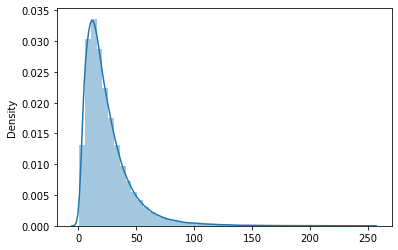

In [ ]:
sns.distplot(k1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


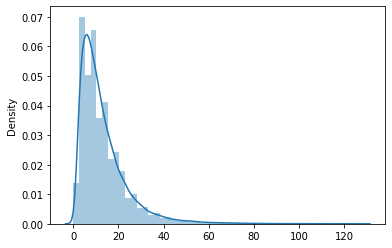

In [ ]:
sns.distplot(k2)

In [ ]:
c1 = []
c2 = []
for tok in answer_mecab:
    c1.append(len(tok))

for tok in ans_tokens_1:
    c2.append(len(tok))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


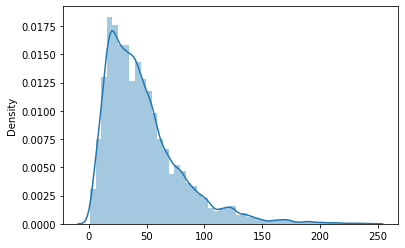

In [ ]:
sns.distplot(c1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


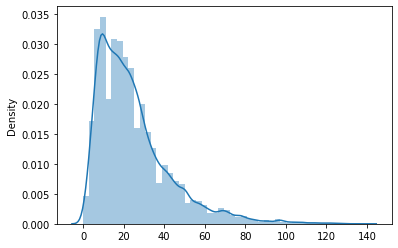

In [ ]:
sns.distplot(c2)